In [1]:
import numpy as np
import cvxpy as cp
import scipy
import mosek
import pandas as pd
import matplotlib.pyplot as plt
from scipy.linalg import sqrtm

In [2]:
n = 10  #number of stocks
T_train = 200 # training period
T_test = 100 #testing period
T_truetest = 100 # out of sample testing period

s = np.loadtxt("10_Industry_Portfolios_Daily.txt")

fulldata = s[504:,1:]
fulldata = 10*fulldata

In [3]:
def missing(miss_prob=0.4):
    #''True'' represents missing
    mask = np.random.choice([True, False], size = (T_train,n), p = [miss_prob, 1-miss_prob])
    mask = np.vstack((mask, np.full((T_test + T_truetest,n),False))) #no missing value for testing period
    return mask

In [4]:
mu_p = np.repeat(0.0,n)
covp_inv = np.diag(np.full(n,0.0))

def individualposterior(data, mask, mu0, cov0_inv,cov, num_points = 50):
    #compute mean and covariance of posterior of \mu given data up to time T in range(...)
    meanlist = []
    covariancelist = []
    num_posteriors = num_points + 1
    
    covariance_mu_inv = np.copy(cov0_inv)
    mean_mu = np.matmul(covariance_mu_inv,mu0)
    
    for t in range(T_train + T_test):
        
        if not np.all(mask[t,:] == np.full(n,True)):
            ind = (mask[t,:] == np.full(n,False))
            cov_t = cov[np.ix_(ind,ind)]
            cov_inv_expand = np.zeros((n,n))
            cov_inv_expand[np.ix_(ind,ind)] = scipy.linalg.pinv(cov_t)

            covariance_mu_inv += cov_inv_expand

            mean_t = np.zeros(n)
            mean_t[ind] = data[t,ind]
            mean_mu += np.matmul(cov_inv_expand,mean_t)
        
        if t >= (T_train - 1):
            if (t - T_train + 1) % (T_test/num_points) == 0:
                covariance_mu = scipy.linalg.pinv(covariance_mu_inv)
                covariancelist.append(covariance_mu)
                meanlist.append(np.matmul(covariance_mu, mean_mu))
    return meanlist,covariancelist  

In [14]:
def consensusforwardkl(meanlist,covariancelist,delta_r, prediction):
    
    num_posteriors = len(meanlist)
    n = len(meanlist[0])
    # Define optimization variables
    weights = cp.Variable(num_posteriors)
    gamma = cp.Variable(n)
    # v, s, vt = np.linalg.svd(covariancelist[0].values)
    
    s, v = np.linalg.eigh(covariancelist[0])
    
    s_list = []
    
    # s_list.append(s)
    
   
    
    # s, v = np.linalg.eigh(covariancelist[1].values)
    # s_list.append(s)
    
    # for i in np.arange(1,num_posteriors,1):
    for i in range(num_posteriors):
        s_temp = np.zeros(n)
        for j in range(n):
            s_temp[j] = np.inner(v[:,j],np.matmul(covariancelist[i],v[:,j]))
        s_list.append(s_temp)
        
    c = np.zeros((num_posteriors,n))
    
    for i in range(num_posteriors):
        for j in range(n):
            c[i, j] = np.inner(v[:,j],meanlist[i])/s_list[i][j]
            
        
    sv_matrix = np.array(s_list)        
    inverse_sv = 1.0 / sv_matrix
    
    #objective_fun = [cp.power(cp.sum(cp.multiply(inverse_sv[:,j], weights)),-1) for j in range(n)]
    
    obj = cp.sum([gamma[j] for j in range(n)])
    
    # Run optimization
    objective = cp.Minimize(obj)
    delta = delta_r * max([np.abs(c[-1,j]/inverse_sv[-1,j] - v[:,j].dot(prediction)) for j in range(n)])
    constraints = [weights >= 0,
                   cp.sum(weights) == 1]
    for j in range(n):
        constraints.append(cp.sum(cp.multiply(c[:,j],weights)) <= (delta + v[:,j].dot(prediction)) * cp.sum(cp.multiply(inverse_sv[:,j], weights)))
        constraints.append(cp.sum(cp.multiply(c[:,j],weights)) >= (-delta + v[:, j].dot(prediction)) * cp.sum(cp.multiply(inverse_sv[:,j], weights)))
        #constraints.append(4 +  cp.power(cp.sum(cp.multiply(inverse_sv[:,j], weights))-gamma[j],2)<= cp.power(cp.sum(cp.multiply(inverse_sv[:,j], weights))+gamma[j],2))   
        A = np.zeros((2,num_posteriors))
        B = np.zeros((2,n))
        B[1,j] = 1 
        for i in range(num_posteriors):
            A[1,i] = inverse_sv[i,j]
        C = np.zeros(2)
        C[0] = 2
        constraints.append(cp.SOC(A[1,:]@weights + B[1,:]@gamma, A @ weights - B @ gamma + C))
                           
                           
    prob = cp.Problem(objective, constraints)
   
    prob.solve()
    
    solution = weights.value
    #print(solution)
    #print(solution)
    
    final_sigma = scipy.linalg.inv(sum([solution[i] * scipy.linalg.inv(covariancelist[i]) for i in range(num_posteriors)]))
    final_mu = final_sigma.dot(sum([solution[i] * np.inner(scipy.linalg.inv(covariancelist[i]), meanlist[i]) for i in range(num_posteriors)]))
    
    return solution, final_mu, final_sigma

In [6]:
def consensuswasserstein(meanlist,covariancelist,delta_r, prediction):
    
    num_posteriors = len(meanlist)
    n = len(meanlist[0])
    
    weights = cp.Variable(2)
        
    Sigma1 = covariancelist[0]
    Sigma2 = covariancelist[-1]
    temp = sqrtm(Sigma2) @ Sigma1 @ sqrtm(Sigma2)
    Psi = sqrtm(Sigma2) @ np.real(scipy.linalg.inv(sqrtm(temp))) @ sqrtm(Sigma2)
    
    P = np.zeros((2,2))
    P[0,0] = np.trace(Sigma1)
    P[1,1] = np.trace(Sigma2)
    P[0,1] = np.trace(Sigma1 @ Psi)
    P[1,0] = np.trace(Sigma1 @ Psi)
   
    obj = cp.quad_form(weights, P)
    
    constraints = [weights >= 0,
                   cp.sum(weights) == 1,
                   weights[1] <= delta_r]
    
    prob = cp.Problem(cp.Minimize(obj), constraints)
    prob.solve()
    
    solution = weights.value
   
    final_mu = meanlist[0] * solution[0] + meanlist[-1] * solution[1]
    final_sigma = (solution[0]*np.eye(n) + solution[1] * Psi) @ Sigma1 @ (solution[0]*np.eye(n) + solution[1] * Psi)
    
    return solution, final_mu, final_sigma

In [7]:
def consensuswasserstein_general(meanlist,covariancelist,delta_r, prediction):
    
    num_posteriors = len(meanlist)
    n = len(meanlist[0])
    
    # Define optimization variables
    weights = cp.Variable(num_posteriors)
    
    # v, s, vt = np.linalg.svd(covariancelist[0].values)
    
    s, v = np.linalg.eigh(covariancelist[0])
    
    s_list = []
    
    # for i in np.arange(1,num_posteriors,1):
    for i in range(num_posteriors):
        s_temp = np.zeros(n)
        for j in range(n):
            s_temp[j] = np.inner(v[:,j],np.matmul(covariancelist[i],v[:,j]))
        s_list.append(s_temp)
    
    sv_matrix = np.array(s_list)
    
    #P = np.zeros((num_posteriors,num_posteriors))
    #for i in range(num_posteriors): 
        #for j in range(num_posteriors):
            #P[i,j] = np.sum(np.multiply(np.sqrt(sv_matrix[i,:]),np.sqrt(sv_matrix[j,:])))
            #np.multiply(np.sqrt(sv_matrix[i,:]),np.sqrt(sv_matrix[j,:]))是(d_{i1}d_{j1})^{1/2}+...+(d_{in}d_{jn})^{1/2},其实可以换成np.inner的
            
    #obj = 0
    #for i in range(num_posteriors): 
    #    for j in range(num_posteriors):
    #        obj += weights[i] * weights[j] * np.sum(np.multiply(np.sqrt(sv_matrix[i,:]),np.sqrt(sv_matrix[j,:])))
    
    
    #obj = cp.sum_squares(weights @ sv_matrix)
    obj = cp.sum_squares(sv_matrix.T @ weights.T)
    #obj = cp.quad_form(weights, P)
    delta = delta_r * np.linalg.norm(meanlist[-1] - prediction)
    constraints = [weights >= 0,
                   cp.sum(weights) == 1]
    temp = 0
    for i in range(num_posteriors):
        temp += weights[i]*meanlist[i]#\sum(\lambda_k\mu_k)
    constraints.append(cp.norm(temp-prediction)<=delta)
    prob = cp.Problem(cp.Minimize(obj), constraints)
    prob.solve(solver=cp.MOSEK)
    
    solution = weights.value
    
    
    final_mu = np.zeros(n)
    for i in range(num_posteriors):
        final_mu += solution[i]*meanlist[i]
    final_sigma = np.zeros((n,n))
    for i in range(num_posteriors):
        for j in range(n):
            final_sigma += solution[i] * np.sqrt(sv_matrix[i,j]) * np.outer(v[:,j],v[:,j])
    final_sigma = final_sigma @ final_sigma
    
    return solution, final_mu, final_sigma

In [20]:
def consensusbackwardkl(meanlist,covariancelist,delta_r,prediction,weight_init,epsilon,max_iter):#weight_init = np.full(num_posteriors,1/num_posteriors)
    
    num_posteriors = len(meanlist)
    n = len(meanlist[0])
    
    # Define optimization variables
    weights = cp.Variable(num_posteriors)
    
    mu_list = []
    
    obj1 = 0
    for i in range(num_posteriors):
        mean_k = meanlist[i]
        mu_list.append(mean_k)
        obj1 += weights[i]*cp.trace(np.outer(mean_k,mean_k)+covariancelist[i])
        
    mu_matrix = np.array(mu_list)
    
    weight_t = weight_init
    weight_former = np.zeros(num_posteriors)
    iteration = 0
    
    while np.linalg.norm(weight_t-weight_former) > epsilon and iteration < max_iter:
        
        weight_former = weight_t
        
        #obj2 = 2*np.inner(np.matmul(mu_matrix,weight_t),np.matmul(mu_matrix,weights))
        obj2 = 2*(np.inner(weight_t,np.inner(mu_matrix,mu_matrix))@ weights)
        
        for i in range(num_posteriors):
            for j in range(num_posteriors):
                obj3 = -weight_t[i]*weight_t[j]*np.inner(meanlist[i],meanlist[j])
        
        obj = obj1+obj2+obj3
    
        delta = delta_r * np.linalg.norm(meanlist[-1] - prediction)
        constraints = [weights >= 0,
                   cp.sum(weights) == 1]
        temp = 0
        for i in range(num_posteriors):
            temp += weights[i]*meanlist[i]#\sum(\lambda_k\mu_k)
        constraints.append(cp.norm(temp-prediction,"inf")<=delta)
        #temp = 0
        #for j in range(n): #j:0,...n-1
        #    for i in range(num_posteriors):
        #        temp += weights[i]*meanlist[i][j]
        #    constraints.append(temp-prediction[j] <= delta)
        #    constraints.append(temp-prediction[j] >= -delta)
            
            
        prob = cp.Problem(cp.Minimize(obj), constraints)
        prob.solve(solver=cp.MOSEK)
    
        weight_t = weights.value
        iteration += 1
        print("weight diff:",np.linalg.norm(weight_t-weight_former))
        print("iteration:",iteration)
    
    final_mu = np.zeros(n)
    for i in range(num_posteriors):
        final_mu += weight_t[i]*meanlist[i]
        
    final_sigma = np.zeros((n,n))
    final_sigma_1 = np.zeros((n,n))
    for i in range(num_posteriors):
        final_sigma_1 += weight_t[i]*(np.outer(meanlist[i],meanlist[i])+covariancelist[i])
    final_sigma = final_sigma_1 - np.outer(final_mu,final_mu)
    
    return weight_t, final_mu, final_sigma

In [9]:
def imputation(data, mask, final_mu,final_sigma):    
    m = 100 #number of multiply-imputed dataset
    total_time,num_stocks = data.shape
    completed_data = np.zeros((m,total_time,num_stocks))
    for k in range(m):
        data_copy = np.copy(data)
        unconditionalmean = np.random.multivariate_normal(final_mu, final_sigma)
        for t in range(T_train):
            if np.all(mask[t,:] == np.full(n,True)):
                data_copy[t,:] = unconditionalmean
            elif np.all(mask[t,:] == np.full(n,False)):
                pass
            else:
                ind_miss = (mask[t,:] == np.full(n,True))
                ind_obs = (mask[t,:] == np.full(n,False))
                len_miss = len(data_copy[t,ind_miss])
                data_copy[t,ind_miss] = np.zeros(len_miss)
                cov11 = cov[np.ix_(ind_miss,ind_obs)]
                cov12_inv = np.linalg.inv(cov[np.ix_(ind_obs,ind_obs)])
                missing_condi_mean = unconditionalmean[ind_miss] + np.matmul(np.matmul(cov11,cov12_inv),data_copy[t,ind_obs] - unconditionalmean[ind_obs])
                missing_condi_cov = cov[np.ix_(ind_miss,ind_miss)] - np.matmul(cov11,np.matmul(cov12_inv,np.matrix.transpose(cov11)))
                data_copy[t,ind_miss] = missing_condi_mean
        completed_data[k,:,:] = data_copy
    return completed_data

In [10]:
def Greedy(data1):
    data = np.copy(data1)
    data = data/10
    mean = np.mean(data[:T_train,:],axis = 0)
    #if np.sum(mean) <= 0:
    #    print('whoops')
    weights = mean / np.linalg.norm(mean,2)
    #c_returns = 1.0
    returns = np.zeros(T_test)
    for t in np.arange(T_train,T_train+T_test,1):
        returns[t-T_train] = np.inner(data[t,:], weights)
        #c_returns *= 1.0 + returns[t-T_train]
    sharper = np.mean(returns)/np.std(returns)
    
    #o_returns = 1.0
    returns_o = np.zeros(T_truetest)
    for t in np.arange(T_train+T_test,T_train+T_test+T_truetest,1):
        returns_o[t-T_train - T_test] = np.inner(data[t,:], weights)
       # o_returns *= 1.0 + returns_o[t-T_train - T_test]
    o_sharper = np.mean(returns_o)/np.std(returns_o)
    
    return sharper, o_sharper,np.mean(returns),np.mean(returns_o)
    #return np.mean(returns),np.mean(returns_o)


In [27]:
n_experiment = 50
m = 100
 
num_delta = 10


mreturn_i_complex = np.zeros((n_experiment,m,num_delta))
mreturn_o_complex = np.zeros((n_experiment,m,num_delta))

mreturn_i_complex_wb = np.zeros((n_experiment,m,num_delta))
mreturn_o_complex_wb = np.zeros((n_experiment,m,num_delta))

mreturn_i_complex_wb_general = np.zeros((n_experiment,m,num_delta))
mreturn_o_complex_wb_general = np.zeros((n_experiment,m,num_delta))

mreturn_i_complex_kl_back = np.zeros((n_experiment,m,num_delta))
mreturn_o_complex_kl_back = np.zeros((n_experiment,m,num_delta))

cov = np.cov(np.matrix.transpose(fulldata))

In [28]:
for k in range(n_experiment):
    print(k)
    data = fulldata[:400,:]
    mask = missing()
    meanlist,covariancelist = individualposterior(data, mask, mu_p, covp_inv,cov)
    
    #get deltas
    deltalist_complex  = np.linspace(0.000, 1.0, num = num_delta)

    for i in range(num_delta):
        #print(i)
        _,final_mu,final_sigma = consensusforwardkl(meanlist,covariancelist,deltalist_complex[i],meanlist[0])
        completed_data = imputation(data,mask,final_mu,final_sigma)
        
        _,final_mu_wb,final_sigma_wb = consensuswasserstein(meanlist,covariancelist,deltalist_complex[i],meanlist[0])
        completed_data_wb = imputation(data,mask,final_mu_wb,final_sigma_wb)
        
        _,final_mu_wb_general,final_sigma_wb_general = consensuswasserstein_general(meanlist,covariancelist,deltalist_complex[i],meanlist[0])
        completed_data_wb_general = imputation(data,mask,final_mu_wb_general,final_sigma_wb_general)
        
        _,final_mu_kl_back,final_sigma_kl_back = consensusbackwardkl(meanlist,covariancelist,deltalist_complex[i],meanlist[0],np.full(len(meanlist),1/len(meanlist)),10**(-14),20)
        completed_data_kl_back = imputation(data,mask,final_mu_kl_back,final_sigma_kl_back)
        
        for j in range(m):
            _, _,mreturn_i_complex[k,j,i], mreturn_o_complex[k,j,i]  = Greedy(completed_data[j])
            _, _,mreturn_i_complex_wb[k,j,i], mreturn_o_complex_wb[k,j,i]  = Greedy(completed_data_wb[j])
            _, _,mreturn_i_complex_wb_general[k,j,i], mreturn_o_complex_wb_general[k,j,i]  = Greedy(completed_data_wb_general[j])
            _, _,mreturn_i_complex_kl_back[k,j,i], mreturn_o_complex_kl_back[k,j,i]  = Greedy(completed_data_kl_back[j])

0
weight diff: 0.9901475429741461
iteration: 1
weight diff: 2.7841176607876062e-09
iteration: 2
weight diff: 2.7868576957173908e-09
iteration: 3
weight diff: 1.1879386714300935e-14
iteration: 4
weight diff: 2.786378810722272e-09
iteration: 5
weight diff: 2.7863793972729554e-09
iteration: 6
weight diff: 2.6181246249648935e-10
iteration: 7
weight diff: 2.9895954743169923e-09
iteration: 8
weight diff: 2.786004657055608e-09
iteration: 9
weight diff: 4.0111137409128636e-10
iteration: 10
weight diff: 4.011113740962064e-10
iteration: 11
weight diff: 2.786450532897882e-09
iteration: 12
weight diff: 9.037192009681899e-13
iteration: 13
weight diff: 2.3591381941913796e-13
iteration: 14
weight diff: 2.7871145755579136e-09
iteration: 15
weight diff: 2.7871380484461666e-09
iteration: 16
weight diff: 8.058987748548099e-13
iteration: 17
weight diff: 4.670730329351984e-13
iteration: 18
weight diff: 2.4056583410953552e-09
iteration: 19
weight diff: 5.35527545761732e-10
iteration: 20
weight diff: 0.58556

weight diff: 0.574179776602281
iteration: 1
weight diff: 1.0933929817824961e-08
iteration: 2
weight diff: 1.0939107361613971e-08
iteration: 3
weight diff: 7.904102161791211e-09
iteration: 4
weight diff: 7.904794931579659e-09
iteration: 5
weight diff: 3.9866100209473934e-07
iteration: 6
weight diff: 3.9866082581613697e-07
iteration: 7
weight diff: 1.1905359173758534e-08
iteration: 8
weight diff: 1.1476955349108267e-08
iteration: 9
weight diff: 9.69278829538878e-09
iteration: 10
weight diff: 5.365268743149503e-08
iteration: 11
weight diff: 4.437315603772173e-08
iteration: 12
weight diff: 4.303590384935526e-14
iteration: 13
weight diff: 2.3991023714368675e-09
iteration: 14
weight diff: 2.3985096280829114e-09
iteration: 15
weight diff: 4.677196629561361e-14
iteration: 16
weight diff: 4.492830964516315e-13
iteration: 17
weight diff: 2.8924538527647446e-13
iteration: 18
weight diff: 5.557592768694394e-09
iteration: 19
weight diff: 5.5579603267433446e-09
iteration: 20
weight diff: 0.680126004

weight diff: 3.697734476958042e-13
iteration: 17
weight diff: 5.536482245668645e-13
iteration: 18
weight diff: 4.675962257330922e-13
iteration: 19
weight diff: 4.788145919249767e-09
iteration: 20
weight diff: 0.6096093075898658
iteration: 1
weight diff: 3.052995811144005e-11
iteration: 2
weight diff: 3.557313899004196e-08
iteration: 3
weight diff: 3.557325820504706e-08
iteration: 4
weight diff: 3.5573055075136314e-08
iteration: 5
weight diff: 4.0998259400501636e-13
iteration: 6
weight diff: 3.558099778091634e-08
iteration: 7
weight diff: 4.474540341127501e-08
iteration: 8
weight diff: 3.445945005139535e-08
iteration: 9
weight diff: 3.398049136965346e-08
iteration: 10
weight diff: 3.3981052375647136e-08
iteration: 11
weight diff: 3.557287988451429e-08
iteration: 12
weight diff: 2.1824101268254372e-13
iteration: 13
weight diff: 3.690455309765788e-09
iteration: 14
weight diff: 3.377663132246775e-08
iteration: 15
weight diff: 7.982739085167713e-13
iteration: 16
weight diff: 3.4294342013372

weight diff: 1.1856461778147257e-10
iteration: 13
weight diff: 8.104628079763643e-15
iteration: 14
weight diff: 0.9901475429763523
iteration: 1
weight diff: 3.51532022878277e-12
iteration: 2
weight diff: 1.7763906741758773e-15
iteration: 3
weight diff: 0.9901475429765412
iteration: 1
weight diff: 8.398712267571779e-13
iteration: 2
weight diff: 2.531308877955757e-14
iteration: 3
weight diff: 2.442617917801564e-15
iteration: 4
weight diff: 0.9901475429765908
iteration: 1
weight diff: 2.1104047434183684e-13
iteration: 2
weight diff: 3.419647052930697e-14
iteration: 3
weight diff: 1.8229865717657491e-13
iteration: 4
weight diff: 1.3056225153284238e-13
iteration: 5
weight diff: 2.1782582342679108e-13
iteration: 6
weight diff: 2.1671575680937128e-13
iteration: 7
weight diff: 3.842035401977548e-14
iteration: 8
weight diff: 1.0947012835422913e-13
iteration: 9
weight diff: 1.1991355859952394e-14
iteration: 10
weight diff: 7.283064033867061e-14
iteration: 11
weight diff: 6.328469067502224e-14
it

weight diff: 3.6742344164032184e-15
iteration: 7
weight diff: 0.7526026012117718
iteration: 1
weight diff: 8.437462603573028e-10
iteration: 2
weight diff: 9.804683940479083e-10
iteration: 3
weight diff: 2.3716002230727968e-14
iteration: 4
weight diff: 9.804606105251507e-10
iteration: 5
weight diff: 1.4748530440384936e-14
iteration: 6
weight diff: 1.1871601875837635e-14
iteration: 7
weight diff: 9.804697273486974e-10
iteration: 8
weight diff: 9.804702937984505e-10
iteration: 9
weight diff: 5.298044297802526e-15
iteration: 10
weight diff: 0.8788569829890576
iteration: 1
weight diff: 1.5182601480151043e-10
iteration: 2
weight diff: 7.556095478958666e-14
iteration: 3
weight diff: 1.4318279532898693e-14
iteration: 4
weight diff: 4.692006020112202e-15
iteration: 5
weight diff: 0.9901475429829479
iteration: 1
weight diff: 6.59800407913168e-12
iteration: 2
weight diff: 2.850034314345838e-15
iteration: 3
weight diff: 0.990147542976819
iteration: 1
weight diff: 3.060700272481369e-13
iteration: 2

weight diff: 1.1180362678725643e-13
iteration: 12
weight diff: 1.2079240249289586e-13
iteration: 13
weight diff: 2.1137580588168072e-12
iteration: 14
weight diff: 2.7012858756273423e-12
iteration: 15
weight diff: 5.92304214861342e-13
iteration: 16
weight diff: 9.131602343786617e-13
iteration: 17
weight diff: 4.117040224938622e-12
iteration: 18
weight diff: 2.7325921401993155e-12
iteration: 19
weight diff: 1.8362007146370944e-12
iteration: 20
weight diff: 0.9901475429764409
iteration: 1
weight diff: 1.9184021869048378e-13
iteration: 2
weight diff: 3.062018585799959e-13
iteration: 3
weight diff: 8.437741969753962e-14
iteration: 4
weight diff: 2.6540389629719078e-14
iteration: 5
weight diff: 4.1999740620146503e-13
iteration: 6
weight diff: 5.684349194269156e-13
iteration: 7
weight diff: 1.938496966088771e-13
iteration: 8
weight diff: 4.416467602358684e-13
iteration: 9
weight diff: 3.665956579227253e-13
iteration: 10
weight diff: 1.1546319987613452e-13
iteration: 11
weight diff: 2.14284975

weight diff: 0.6505825309397261
iteration: 1
weight diff: 0.024927458729213346
iteration: 2
weight diff: 9.238254116118634e-12
iteration: 3
weight diff: 6.384104190353149e-12
iteration: 4
weight diff: 5.332324485337424e-12
iteration: 5
weight diff: 7.440527159231539e-12
iteration: 6
weight diff: 7.78827614202329e-12
iteration: 7
weight diff: 7.847187094946754e-09
iteration: 8
weight diff: 7.839523821458484e-09
iteration: 9
weight diff: 1.8901727545626316e-11
iteration: 10
weight diff: 3.4282151684068637e-13
iteration: 11
weight diff: 2.4692813468422906e-12
iteration: 12
weight diff: 2.8795212958185876e-12
iteration: 13
weight diff: 1.1517116965455693e-12
iteration: 14
weight diff: 4.278350244216868e-12
iteration: 15
weight diff: 1.0230961423455318e-08
iteration: 16
weight diff: 1.0255650378490542e-08
iteration: 17
weight diff: 1.758022945661866e-10
iteration: 18
weight diff: 5.49570711809214e-09
iteration: 19
weight diff: 1.3080212733213412e-09
iteration: 20
weight diff: 0.629735692548

weight diff: 0.6373310005858804
iteration: 1
weight diff: 7.877151271912276e-11
iteration: 2
weight diff: 4.9597653082120545e-12
iteration: 3
weight diff: 3.119117184534334e-12
iteration: 4
weight diff: 2.674891133412527e-12
iteration: 5
weight diff: 3.771089748850452e-12
iteration: 6
weight diff: 3.837215203563481e-12
iteration: 7
weight diff: 6.582036621817655e-12
iteration: 8
weight diff: 5.137383796061492e-12
iteration: 9
weight diff: 3.774566438848397e-14
iteration: 10
weight diff: 1.0551808748747894e-13
iteration: 11
weight diff: 7.663436567228625e-14
iteration: 12
weight diff: 6.916948722730468e-12
iteration: 13
weight diff: 3.28936531962108e-12
iteration: 14
weight diff: 1.1717080335454172e-11
iteration: 15
weight diff: 7.707508153996592e-12
iteration: 16
weight diff: 1.6235493249329498e-12
iteration: 17
weight diff: 4.8474852767611456e-12
iteration: 18
weight diff: 5.56061328192854e-14
iteration: 19
weight diff: 1.4661718304983344e-12
iteration: 20
weight diff: 0.7596081610206

weight diff: 0.9901475429765892
iteration: 1
weight diff: 1.177292573144608e-13
iteration: 2
weight diff: 1.8988420965870558e-14
iteration: 3
weight diff: 6.961293178911421e-14
iteration: 4
weight diff: 5.33464701045768e-13
iteration: 5
weight diff: 2.4992778838305096e-13
iteration: 6
weight diff: 4.3143816449099806e-13
iteration: 7
weight diff: 6.548101223978218e-13
iteration: 8
weight diff: 3.692773878995212e-13
iteration: 9
weight diff: 1.4472751778857768e-14
iteration: 10
weight diff: 1.4251468713685534e-14
iteration: 11
weight diff: 1.3212170584059447e-13
iteration: 12
weight diff: 6.128452318941013e-13
iteration: 13
weight diff: 9.3991539243767e-13
iteration: 14
weight diff: 1.88519620766001e-13
iteration: 15
weight diff: 1.1769828534045084e-14
iteration: 16
weight diff: 4.496474378188773e-14
iteration: 17
weight diff: 3.9957605276908423e-13
iteration: 18
weight diff: 3.1119640068252884e-13
iteration: 19
weight diff: 4.887922015588267e-14
iteration: 20
weight diff: 0.990147542976

weight diff: 0.9901475429755235
iteration: 1
weight diff: 1.394099395935043e-09
iteration: 2
weight diff: 1.3947432098944374e-09
iteration: 3
weight diff: 1.5118748572573501e-09
iteration: 4
weight diff: 1.5117471816105783e-09
iteration: 5
weight diff: 1.1046719095020318e-13
iteration: 6
weight diff: 3.5170485432026925e-09
iteration: 7
weight diff: 1.0132920391671004e-08
iteration: 8
weight diff: 6.034910571407516e-09
iteration: 9
weight diff: 4.611962027372488e-10
iteration: 10
weight diff: 7.371255717224945e-09
iteration: 11
weight diff: 1.1884706553120011e-08
iteration: 12
weight diff: 4.92059804264623e-09
iteration: 13
weight diff: 5.667201491388504e-09
iteration: 14
weight diff: 2.0778567654235875e-10
iteration: 15
weight diff: 8.65879701292334e-09
iteration: 16
weight diff: 3.310624335475093e-09
iteration: 17
weight diff: 3.790857856856358e-09
iteration: 18
weight diff: 8.366845995035285e-09
iteration: 19
weight diff: 4.576036661543553e-09
iteration: 20
weight diff: 0.99014754297

weight diff: 3.7756497083793427e-13
iteration: 17
weight diff: 2.2502013926522894e-12
iteration: 18
weight diff: 2.4003795188289657e-12
iteration: 19
weight diff: 3.937484658049291e-12
iteration: 20
weight diff: 0.7881492896231644
iteration: 1
weight diff: 5.478367611983979e-09
iteration: 2
weight diff: 2.0843101716302308e-13
iteration: 3
weight diff: 1.2908155278997663e-13
iteration: 4
weight diff: 7.087139818432291e-11
iteration: 5
weight diff: 7.100198081092365e-11
iteration: 6
weight diff: 1.5989853012392094e-10
iteration: 7
weight diff: 5.636970741417402e-10
iteration: 8
weight diff: 6.811917034094837e-10
iteration: 9
weight diff: 8.191813415511877e-13
iteration: 10
weight diff: 8.073627184753639e-13
iteration: 11
weight diff: 1.8438241126213098e-13
iteration: 12
weight diff: 4.139398336277833e-13
iteration: 13
weight diff: 8.848592485048554e-10
iteration: 14
weight diff: 8.849058410965098e-10
iteration: 15
weight diff: 6.483830921116321e-13
iteration: 16
weight diff: 2.0787106184

weight diff: 0.6974399698119917
iteration: 1
weight diff: 6.269499803940399e-10
iteration: 2
weight diff: 2.7805507843080685e-15
iteration: 3
weight diff: 0.7700684542242116
iteration: 1
weight diff: 3.221701726675197e-10
iteration: 2
weight diff: 2.8839629088098005e-10
iteration: 3
weight diff: 2.0003523088352752e-10
iteration: 4
weight diff: 8.55955589140535e-10
iteration: 5
weight diff: 6.395948737724186e-10
iteration: 6
weight diff: 6.39599047973513e-10
iteration: 7
weight diff: 4.668635096675244e-10
iteration: 8
weight diff: 2.9143615666855726e-10
iteration: 9
weight diff: 1.6066409681077886e-12
iteration: 10
weight diff: 1.6023454998859363e-12
iteration: 11
weight diff: 3.614624287906422e-15
iteration: 12
weight diff: 0.9124897534974744
iteration: 1
weight diff: 3.3689280480418445e-12
iteration: 2
weight diff: 2.6797474312968864e-13
iteration: 3
weight diff: 2.4786645910442713e-13
iteration: 4
weight diff: 2.8853539054166556e-13
iteration: 5
weight diff: 3.07165983629692e-13
iter

weight diff: 5.799805084671904e-12
iteration: 6
weight diff: 7.800426974628075e-13
iteration: 7
weight diff: 3.210765089760635e-13
iteration: 8
weight diff: 1.1922685075507824e-12
iteration: 9
weight diff: 1.1916023737368668e-12
iteration: 10
weight diff: 1.1162182336821578e-12
iteration: 11
weight diff: 1.2729817200352826e-12
iteration: 12
weight diff: 7.505149020486627e-14
iteration: 13
weight diff: 2.23599101544815e-13
iteration: 14
weight diff: 3.4191538498918064e-12
iteration: 15
weight diff: 5.629941343825444e-13
iteration: 16
weight diff: 3.014921663713133e-12
iteration: 17
weight diff: 1.2989611766290725e-13
iteration: 18
weight diff: 1.0842438067716376e-12
iteration: 19
weight diff: 7.431832949206838e-13
iteration: 20
16
weight diff: 0.9901475429613202
iteration: 1
weight diff: 1.047323273748567e-10
iteration: 2
weight diff: 1.9237583378167252e-13
iteration: 3
weight diff: 3.154114270149445e-14
iteration: 4
weight diff: 1.6979662909984199e-13
iteration: 5
weight diff: 1.618926

weight diff: 1.1966784393867294e-10
iteration: 6
weight diff: 1.2732942624775497e-10
iteration: 7
weight diff: 5.659228727410826e-12
iteration: 8
weight diff: 1.18817934797696e-10
iteration: 9
weight diff: 1.4114491292290403e-10
iteration: 10
weight diff: 5.5232764824119255e-11
iteration: 11
weight diff: 7.470278016933855e-11
iteration: 12
weight diff: 4.381945724565031e-11
iteration: 13
weight diff: 3.4664274415256104e-11
iteration: 14
weight diff: 5.3774264988891235e-11
iteration: 15
weight diff: 5.3781262093890756e-11
iteration: 16
weight diff: 1.6576995673455834e-15
iteration: 17
weight diff: 0.8345507641941341
iteration: 1
weight diff: 3.638770065826569e-11
iteration: 2
weight diff: 1.2971012650598798e-12
iteration: 3
weight diff: 6.040898003077518e-12
iteration: 4
weight diff: 6.166933889269126e-12
iteration: 5
weight diff: 1.6183214388048242e-14
iteration: 6
weight diff: 1.269933725419279e-12
iteration: 7
weight diff: 1.2780709480319905e-12
iteration: 8
weight diff: 1.7104732377

weight diff: 4.457618893596374e-14
iteration: 7
weight diff: 1.898640211172999e-12
iteration: 8
weight diff: 4.43160671385181e-12
iteration: 9
weight diff: 4.33884379212178e-12
iteration: 10
weight diff: 4.235206175914605e-14
iteration: 11
weight diff: 2.1715079728129802e-15
iteration: 12
weight diff: 0.9011578100427192
iteration: 1
weight diff: 4.821037238616968e-10
iteration: 2
weight diff: 4.825571541896289e-10
iteration: 3
weight diff: 4.82563665310372e-10
iteration: 4
weight diff: 4.825622694314647e-10
iteration: 5
weight diff: 4.825593116098122e-10
iteration: 6
weight diff: 4.825612340652243e-10
iteration: 7
weight diff: 3.1093988026334558e-15
iteration: 8
weight diff: 0.9901475429816365
iteration: 1
weight diff: 2.372457479510428e-11
iteration: 2
weight diff: 9.44244684720315e-13
iteration: 3
weight diff: 4.672962025082842e-11
iteration: 4
weight diff: 4.550315687351626e-11
iteration: 5
weight diff: 1.4809264967637048e-12
iteration: 6
weight diff: 6.306066780943736e-13
iteration

weight diff: 5.440210721891339e-14
iteration: 12
weight diff: 8.85966484569583e-14
iteration: 13
weight diff: 7.549655153099015e-15
iteration: 14
20
weight diff: 0.9901475424086015
iteration: 1
weight diff: 5.736529043154688e-10
iteration: 2
weight diff: 8.945296068894873e-10
iteration: 3
weight diff: 1.0439607651134025e-09
iteration: 4
weight diff: 1.9336443841680117e-10
iteration: 5
weight diff: 3.790812109758357e-10
iteration: 6
weight diff: 3.7908498570132294e-10
iteration: 7
weight diff: 8.945030632832644e-10
iteration: 8
weight diff: 8.77538309041737e-14
iteration: 9
weight diff: 8.735978729083364e-10
iteration: 10
weight diff: 8.735077894864873e-10
iteration: 11
weight diff: 8.945076766320986e-10
iteration: 12
weight diff: 2.68354457338621e-10
iteration: 13
weight diff: 1.1066263387882883e-09
iteration: 14
weight diff: 2.1033651430270287e-13
iteration: 15
weight diff: 8.946568126887504e-10
iteration: 16
weight diff: 8.944931231389864e-10
iteration: 17
weight diff: 8.267204623629

weight diff: 0.713386908411779
iteration: 6
weight diff: 0.713386908411686
iteration: 7
weight diff: 0.713386908411671
iteration: 8
weight diff: 0.7133869084095715
iteration: 9
weight diff: 0.7133869084095863
iteration: 10
weight diff: 0.7133869083691117
iteration: 11
weight diff: 0.7133869083691259
iteration: 12
weight diff: 0.7133869084093974
iteration: 13
weight diff: 0.7133869084093781
iteration: 14
weight diff: 0.7133869081944081
iteration: 15
weight diff: 0.7133869081944216
iteration: 16
weight diff: 0.7133869084114527
iteration: 17
weight diff: 0.7133869084114131
iteration: 18
weight diff: 0.7133869084060033
iteration: 19
weight diff: 0.7133869084060425
iteration: 20
weight diff: 0.615710018485273
iteration: 1
weight diff: 1.5233246277144306e-12
iteration: 2
weight diff: 8.553953649638008e-15
iteration: 3
weight diff: 0.6615703206976075
iteration: 1
weight diff: 1.2722121932748981e-09
iteration: 2
weight diff: 2.7364805313575178e-14
iteration: 3
weight diff: 1.9793525383011978e-

weight diff: 1.352917790148624e-12
iteration: 17
weight diff: 1.6629586597416368e-11
iteration: 18
weight diff: 1.6523338253964187e-11
iteration: 19
weight diff: 1.1124435185494726e-13
iteration: 20
weight diff: 0.9901475429762339
iteration: 1
weight diff: 6.389537452163139e-13
iteration: 2
weight diff: 2.7900462982494387e-13
iteration: 3
weight diff: 2.1790347369714685e-12
iteration: 4
weight diff: 1.8817199348142954e-12
iteration: 5
weight diff: 1.4502927287234362e-12
iteration: 6
weight diff: 1.4522911186315204e-12
iteration: 7
weight diff: 4.440892098502027e-16
iteration: 8
weight diff: 0.9901475429766446
iteration: 1
weight diff: 2.970056515561018e-13
iteration: 2
weight diff: 6.955547339372445e-13
iteration: 3
weight diff: 8.669731653952126e-13
iteration: 4
weight diff: 1.143531090169492e-13
iteration: 5
weight diff: 1.1861623758026463e-12
iteration: 6
weight diff: 1.563083068280117e-12
iteration: 7
weight diff: 6.674661254989688e-13
iteration: 8
weight diff: 2.327028720679568e-1

weight diff: 1.7190095789701666e-12
iteration: 6
weight diff: 3.6022360020282137e-12
iteration: 7
weight diff: 2.1667816294065655e-12
iteration: 8
weight diff: 1.3930468283727051e-12
iteration: 9
weight diff: 3.204990832219899e-12
iteration: 10
weight diff: 2.3897299033279606e-12
iteration: 11
weight diff: 2.850621556389461e-12
iteration: 12
weight diff: 1.6667304940852113e-12
iteration: 13
weight diff: 7.322720248765355e-13
iteration: 14
weight diff: 1.2088244521642115e-12
iteration: 15
weight diff: 2.325054462094959e-12
iteration: 16
weight diff: 5.264188851852361e-12
iteration: 17
weight diff: 1.9757054361981595e-12
iteration: 18
weight diff: 3.019055229356528e-12
iteration: 19
weight diff: 1.1362337333349399e-12
iteration: 20
weight diff: 0.7041410775246711
iteration: 1
weight diff: 1.42686001540479e-09
iteration: 2
weight diff: 5.904114061900395e-14
iteration: 3
weight diff: 8.708033079901574e-14
iteration: 4
weight diff: 1.5892287503899372e-13
iteration: 5
weight diff: 1.89127058

weight diff: 0.9901475429766474
iteration: 1
weight diff: 3.301899390477329e-12
iteration: 2
weight diff: 3.3164595216851758e-12
iteration: 3
weight diff: 7.950313591103524e-13
iteration: 4
weight diff: 7.656098815705313e-13
iteration: 5
weight diff: 2.906569825789657e-13
iteration: 6
weight diff: 2.433646664763018e-13
iteration: 7
weight diff: 1.9129163146758237e-13
iteration: 8
weight diff: 3.75034200253135e-13
iteration: 9
weight diff: 2.34260288319729e-13
iteration: 10
weight diff: 1.998401522429835e-15
iteration: 11
weight diff: 0.9901475429766728
iteration: 1
weight diff: 9.25348899919721e-13
iteration: 2
weight diff: 8.510971726617742e-13
iteration: 3
weight diff: 7.149836320742263e-14
iteration: 4
weight diff: 2.237099795588847e-12
iteration: 5
weight diff: 3.958500227296157e-12
iteration: 6
weight diff: 1.543321106642867e-12
iteration: 7
weight diff: 3.630434599771836e-13
iteration: 8
weight diff: 2.1995739433398276e-12
iteration: 9
weight diff: 4.9942272671781675e-12
iteratio

weight diff: 8.065665635849094e-13
iteration: 17
weight diff: 7.810018613031894e-13
iteration: 18
weight diff: 4.825439330477688e-13
iteration: 19
weight diff: 2.9614523493683767e-13
iteration: 20
weight diff: 0.7140414790412982
iteration: 1
weight diff: 1.855226997262388e-08
iteration: 2
weight diff: 2.0622601648083905e-13
iteration: 3
weight diff: 1.8630024988541937e-08
iteration: 4
weight diff: 1.859424709704331e-14
iteration: 5
weight diff: 1.8630131257548253e-08
iteration: 6
weight diff: 1.8630120274500307e-08
iteration: 7
weight diff: 1.8630053484032606e-08
iteration: 8
weight diff: 1.2408564215982627e-13
iteration: 9
weight diff: 4.649260802437486e-14
iteration: 10
weight diff: 2.363953426109393e-14
iteration: 11
weight diff: 1.1212054772287247e-13
iteration: 12
weight diff: 1.1820513718861903e-13
iteration: 13
weight diff: 1.2101146284899678e-13
iteration: 14
weight diff: 1.8630044408787014e-08
iteration: 15
weight diff: 1.8630100724733322e-08
iteration: 16
weight diff: 2.46546

weight diff: 2.1225121722720644e-13
iteration: 18
weight diff: 3.69676039093361e-13
iteration: 19
weight diff: 1.0449061442737012e-07
iteration: 20
weight diff: 0.7577255540501113
iteration: 1
weight diff: 0.11039456847890383
iteration: 2
weight diff: 4.092310863480533e-08
iteration: 3
weight diff: 1.9194573508024156e-07
iteration: 4
weight diff: 7.548964704062513e-13
iteration: 5
weight diff: 1.9210378837234415e-07
iteration: 6
weight diff: 1.0473677328288102e-14
iteration: 7
weight diff: 2.2705960916382398e-14
iteration: 8
weight diff: 1.5336581849312488e-14
iteration: 9
weight diff: 1.9210447840908269e-07
iteration: 10
weight diff: 7.89263333289852e-13
iteration: 11
weight diff: 1.9210370831810323e-07
iteration: 12
weight diff: 2.62919762986221e-14
iteration: 13
weight diff: 1.9210449064441027e-07
iteration: 14
weight diff: 1.9210449983647491e-07
iteration: 15
weight diff: 1.9210458269287097e-07
iteration: 16
weight diff: 1.921045823954463e-07
iteration: 17
weight diff: 1.9210451444

weight diff: 0.9901475429764937
iteration: 1
weight diff: 4.552138489234777e-13
iteration: 2
weight diff: 1.776357234838953e-15
iteration: 3
weight diff: 0.9901475429786893
iteration: 1
weight diff: 2.4208703630627205e-12
iteration: 2
weight diff: 3.9390720846941296e-13
iteration: 3
weight diff: 2.2204460492503154e-15
iteration: 4
30
weight diff: 0.9901475429316448
iteration: 1
weight diff: 5.812971454986902e-11
iteration: 2
weight diff: 9.311440802562022e-13
iteration: 3
weight diff: 2.8166419246430645e-13
iteration: 4
weight diff: 4.797617941995304e-15
iteration: 5
weight diff: 0.8215855425811449
iteration: 1
weight diff: 1.7981569439695766e-10
iteration: 2
weight diff: 1.9704883218348492e-13
iteration: 3
weight diff: 7.784504917413232e-14
iteration: 4
weight diff: 8.578885661197022e-14
iteration: 5
weight diff: 1.9720417537956586e-13
iteration: 6
weight diff: 1.9904516244756456e-13
iteration: 7
weight diff: 1.7662882677947232e-13
iteration: 8
weight diff: 1.972633748754727e-13
itera

weight diff: 3.036365474376455e-14
iteration: 18
weight diff: 6.281338755463142e-14
iteration: 19
weight diff: 8.316383369309173e-14
iteration: 20
weight diff: 0.714224384080458
iteration: 1
weight diff: 6.555775235381975e-10
iteration: 2
weight diff: 2.1339310710008587e-15
iteration: 3
weight diff: 0.8340079908275334
iteration: 1
weight diff: 1.0922604454109527e-10
iteration: 2
weight diff: 3.426171528794216e-15
iteration: 3
weight diff: 0.9607230054962306
iteration: 1
weight diff: 1.4890954245482366e-12
iteration: 2
weight diff: 2.5504281880543245e-15
iteration: 3
weight diff: 0.9901475429762154
iteration: 1
weight diff: 3.3368070551597877e-11
iteration: 2
weight diff: 4.46872492873578e-12
iteration: 3
weight diff: 2.9505453179248374e-11
iteration: 4
weight diff: 1.753752782260449e-11
iteration: 5
weight diff: 1.7539304164550865e-11
iteration: 6
weight diff: 7.771567511024376e-16
iteration: 7
weight diff: 0.9901475429766744
iteration: 1
weight diff: 8.669321316776275e-13
iteration: 2

weight diff: 7.41107175635456e-12
iteration: 17
weight diff: 1.8060664079856762e-11
iteration: 18
weight diff: 6.372680168456789e-13
iteration: 19
weight diff: 8.731571023994365e-12
iteration: 20
33
weight diff: 0.9901475424783865
iteration: 1
weight diff: 6.642169112278545e-10
iteration: 2
weight diff: 5.3809346664636073e-14
iteration: 3
weight diff: 1.0953761614118921e-10
iteration: 4
weight diff: 1.0954391004270965e-10
iteration: 5
weight diff: 2.377449882681397e-14
iteration: 6
weight diff: 1.095516209382026e-10
iteration: 7
weight diff: 1.0949889876520394e-10
iteration: 8
weight diff: 1.0950488887544142e-10
iteration: 9
weight diff: 1.5543331350630225e-15
iteration: 10
weight diff: 0.8127133663126904
iteration: 1
weight diff: 3.583644898249433e-11
iteration: 2
weight diff: 5.689774261078077e-11
iteration: 3
weight diff: 1.6677931505469976e-11
iteration: 4
weight diff: 2.701067906037741e-13
iteration: 5
weight diff: 4.3605147503445304e-13
iteration: 6
weight diff: 5.725763791178263

weight diff: 1.7306358748125096e-13
iteration: 17
weight diff: 2.008047251877961e-13
iteration: 18
weight diff: 9.129220451325e-14
iteration: 19
weight diff: 1.429994452175911e-13
iteration: 20
weight diff: 0.6555167033548125
iteration: 1
weight diff: 4.420533015963333e-10
iteration: 2
weight diff: 8.245463710638113e-14
iteration: 3
weight diff: 4.6105181473249523e-14
iteration: 4
weight diff: 6.310004426219328e-14
iteration: 5
weight diff: 7.707376219623777e-14
iteration: 6
weight diff: 1.7118860963739382e-13
iteration: 7
weight diff: 1.1823355439636494e-13
iteration: 8
weight diff: 7.561947579093368e-14
iteration: 9
weight diff: 1.1608205993046269e-13
iteration: 10
weight diff: 1.3395948370395664e-13
iteration: 11
weight diff: 7.31773130634722e-14
iteration: 12
weight diff: 1.555994386826187e-13
iteration: 13
weight diff: 2.2844629250182245e-13
iteration: 14
weight diff: 5.460174681376742e-14
iteration: 15
weight diff: 4.0434315598151475e-14
iteration: 16
weight diff: 1.3957438768386

weight diff: 0.6540734178309244
iteration: 1
weight diff: 1.0590646319733196e-08
iteration: 2
weight diff: 3.839425133032646e-12
iteration: 3
weight diff: 1.0612742048550287e-08
iteration: 4
weight diff: 1.0614897506250994e-08
iteration: 5
weight diff: 1.0504932797860906e-11
iteration: 6
weight diff: 5.514953606692836e-12
iteration: 7
weight diff: 1.06163666370615e-08
iteration: 8
weight diff: 1.0614560185148228e-08
iteration: 9
weight diff: 3.191082731908952e-12
iteration: 10
weight diff: 5.276491478502133e-12
iteration: 11
weight diff: 2.2969014752088107e-12
iteration: 12
weight diff: 1.8920748763990867e-10
iteration: 13
weight diff: 1.0441412092971362e-08
iteration: 14
weight diff: 1.061294534683105e-08
iteration: 15
weight diff: 8.800395969766712e-12
iteration: 16
weight diff: 1.0615403365616836e-08
iteration: 17
weight diff: 2.661540259468007e-12
iteration: 18
weight diff: 9.719817169939653e-13
iteration: 19
weight diff: 1.0612999136977505e-08
iteration: 20
weight diff: 0.77502479

weight diff: 2.5712795823055606e-10
iteration: 7
weight diff: 1.0929845426722897e-09
iteration: 8
weight diff: 5.0108740016489736e-14
iteration: 9
weight diff: 5.6476424555608603e-14
iteration: 10
weight diff: 2.0472705561502302e-14
iteration: 11
weight diff: 4.951712531515356e-15
iteration: 12
weight diff: 0.7649543505541454
iteration: 1
weight diff: 8.512597989757706e-09
iteration: 2
weight diff: 5.731458486555205e-11
iteration: 3
weight diff: 1.7516359488641226e-13
iteration: 4
weight diff: 5.038448303190269e-13
iteration: 5
weight diff: 1.4327557406873018e-13
iteration: 6
weight diff: 1.5113524895886973e-11
iteration: 7
weight diff: 1.4163630802399084e-11
iteration: 8
weight diff: 5.336880512424694e-13
iteration: 9
weight diff: 1.3299084023550814e-11
iteration: 10
weight diff: 1.4127055430038051e-11
iteration: 11
weight diff: 2.3573009071086826e-14
iteration: 12
weight diff: 7.126676469115002e-13
iteration: 13
weight diff: 8.523470112581113e-13
iteration: 14
weight diff: 5.96084210

weight diff: 0.6945649269216234
iteration: 1
weight diff: 3.4469461408328507e-09
iteration: 2
weight diff: 9.562659499185397e-10
iteration: 3
weight diff: 8.413005473008349e-14
iteration: 4
weight diff: 5.4845187011625856e-14
iteration: 5
weight diff: 9.562772386692372e-10
iteration: 6
weight diff: 1.44900321144303e-14
iteration: 7
weight diff: 1.2772209980170615e-14
iteration: 8
weight diff: 4.48482351574743e-15
iteration: 9
weight diff: 0.8689816913451894
iteration: 1
weight diff: 2.2434176150529486e-10
iteration: 2
weight diff: 1.5433697501726863e-15
iteration: 3
weight diff: 0.9901475430182111
iteration: 1
weight diff: 4.197764477821446e-11
iteration: 2
weight diff: 1.1324274851181303e-14
iteration: 3
weight diff: 3.4538039095529024e-11
iteration: 4
weight diff: 1.7339152336218425e-10
iteration: 5
weight diff: 1.7674106622723847e-10
iteration: 6
weight diff: 1.5827561483666202e-10
iteration: 7
weight diff: 1.209621292024162e-10
iteration: 8
weight diff: 6.725775492101071e-11
iterat

weight diff: 3.6970427507814956e-14
iteration: 11
weight diff: 1.3988892729955886e-14
iteration: 12
weight diff: 6.13953333180715e-14
iteration: 13
weight diff: 5.773160280347535e-14
iteration: 14
weight diff: 2.5313096970633712e-14
iteration: 15
weight diff: 5.329072186721494e-14
iteration: 16
weight diff: 8.881784501356654e-14
iteration: 17
weight diff: 4.6407347446589626e-14
iteration: 18
weight diff: 3.7747645029923436e-14
iteration: 19
weight diff: 5.95079550024947e-14
iteration: 20
weight diff: 0.9901475429784754
iteration: 1
weight diff: 1.509841276455887e-12
iteration: 2
weight diff: 4.123591460761042e-12
iteration: 3
weight diff: 7.40363495923013e-12
iteration: 4
weight diff: 3.144917738941043e-11
iteration: 5
weight diff: 3.8278603171651096e-11
iteration: 6
weight diff: 7.254752354436987e-12
iteration: 7
weight diff: 2.520207971739484e-12
iteration: 8
weight diff: 1.892486774094178e-12
iteration: 9
weight diff: 7.047703256388383e-13
iteration: 10
weight diff: 1.03483509611811

weight diff: 3.2042634563484613e-10
iteration: 11
weight diff: 5.453822204652805e-10
iteration: 12
weight diff: 5.584810157479833e-10
iteration: 13
weight diff: 1.0000863373804059e-09
iteration: 14
weight diff: 5.579629651787635e-10
iteration: 15
weight diff: 1.0526281682895837e-09
iteration: 16
weight diff: 3.3645497643975133e-10
iteration: 17
weight diff: 3.948284104887669e-10
iteration: 18
weight diff: 3.321039128278605e-10
iteration: 19
weight diff: 9.366923464458306e-10
iteration: 20
weight diff: 0.6752524991171933
iteration: 1
weight diff: 6.765235341712318e-09
iteration: 2
weight diff: 2.1890529088593905e-08
iteration: 3
weight diff: 1.3413356170263361e-09
iteration: 4
weight diff: 1.7541684737836016e-09
iteration: 5
weight diff: 1.376182062911948e-09
iteration: 6
weight diff: 1.1579626975428776e-09
iteration: 7
weight diff: 5.314223399080538e-10
iteration: 8
weight diff: 5.314303606256039e-10
iteration: 9
weight diff: 1.720383680447765e-10
iteration: 10
weight diff: 1.720395630

weight diff: 4.44290779080923e-12
iteration: 11
weight diff: 5.724587829433798e-12
iteration: 12
weight diff: 5.7300250349514795e-12
iteration: 13
weight diff: 6.925188393378701e-13
iteration: 14
weight diff: 1.2561956397161555e-12
iteration: 15
weight diff: 1.937896112620583e-12
iteration: 16
weight diff: 9.673746138792538e-13
iteration: 17
weight diff: 9.611983321656977e-13
iteration: 18
weight diff: 1.3955024330665427e-13
iteration: 19
weight diff: 7.139981970312222e-14
iteration: 20
weight diff: 0.9901475429796608
iteration: 1
weight diff: 7.102350806243279e-13
iteration: 2
weight diff: 6.679762274030184e-16
iteration: 3
weight diff: 0.9901475429769968
iteration: 1
weight diff: 7.433104429876061e-14
iteration: 2
weight diff: 1.7230677280754525e-13
iteration: 3
weight diff: 6.900036216937112e-13
iteration: 4
weight diff: 7.71049890996083e-13
iteration: 5
weight diff: 2.8421715295442787e-13
iteration: 6
weight diff: 8.881784202489742e-16
iteration: 7
weight diff: 0.9901475429767836
i

weight diff: 5.55112326824308e-16
iteration: 6
43
weight diff: 0.9901475429144344
iteration: 1
weight diff: 6.347507802432261e-11
iteration: 2
weight diff: 9.083095929383706e-15
iteration: 3
weight diff: 0.8022562788870935
iteration: 1
weight diff: 0.12123895895650948
iteration: 2
weight diff: 6.130164103657868e-11
iteration: 3
weight diff: 3.708097199169577e-13
iteration: 4
weight diff: 1.8652621071124373e-13
iteration: 5
weight diff: 5.034137929660733e-13
iteration: 6
weight diff: 3.559910292520138e-13
iteration: 7
weight diff: 2.272217343403256e-13
iteration: 8
weight diff: 2.205853470643451e-13
iteration: 9
weight diff: 8.649578405057544e-14
iteration: 10
weight diff: 1.4185413488763108e-13
iteration: 11
weight diff: 8.239793757798311e-14
iteration: 12
weight diff: 1.2498651997506157e-13
iteration: 13
weight diff: 3.930622882388802e-13
iteration: 14
weight diff: 3.0139295032059466e-13
iteration: 15
weight diff: 1.6253082391386502e-13
iteration: 16
weight diff: 2.372614305030105e-13

weight diff: 4.014648156331178e-12
iteration: 20
weight diff: 0.6230960573745128
iteration: 1
weight diff: 0.10464323902383371
iteration: 2
weight diff: 0.10464324019362921
iteration: 3
weight diff: 0.10464324019333415
iteration: 4
weight diff: 0.10464324019333315
iteration: 5
weight diff: 0.10464324019352607
iteration: 6
weight diff: 0.10464324019356795
iteration: 7
weight diff: 0.10464324199092764
iteration: 8
weight diff: 0.10464324199089471
iteration: 9
weight diff: 0.10464324019323037
iteration: 10
weight diff: 0.10464324019318966
iteration: 11
weight diff: 0.1046432401936682
iteration: 12
weight diff: 0.10464324019371898
iteration: 13
weight diff: 0.10464323797463965
iteration: 14
weight diff: 0.10464323797466099
iteration: 15
weight diff: 0.10464324019352107
iteration: 16
weight diff: 0.10464324019352479
iteration: 17
weight diff: 0.10464325024425886
iteration: 18
weight diff: 0.10464325024426452
iteration: 19
weight diff: 0.10464324037737414
iteration: 20
weight diff: 0.6139936

weight diff: 3.197442624123376e-13
iteration: 6
weight diff: 2.2981742287800915e-13
iteration: 7
weight diff: 9.550915714091258e-15
iteration: 8
46
weight diff: 0.9901475429752064
iteration: 1
weight diff: 2.3193724905683667e-09
iteration: 2
weight diff: 2.3209299275164614e-09
iteration: 3
weight diff: 5.55299450417558e-16
iteration: 4
weight diff: 0.8029446168297791
iteration: 1
weight diff: 1.9983466597700647e-09
iteration: 2
weight diff: 1.5104771940103902e-14
iteration: 3
weight diff: 3.356093289485253e-14
iteration: 4
weight diff: 8.62948476783683e-15
iteration: 5
weight diff: 0.7050840066652586
iteration: 1
weight diff: 1.1268236222592032e-09
iteration: 2
weight diff: 1.126434246543304e-09
iteration: 3
weight diff: 1.126435494301428e-09
iteration: 4
weight diff: 5.438509397572246e-14
iteration: 5
weight diff: 1.1264075851486782e-09
iteration: 6
weight diff: 2.2060008575423784e-14
iteration: 7
weight diff: 1.1264353326665629e-09
iteration: 8
weight diff: 1.1423080364971472e-13
ite

weight diff: 0.9901475429737365
iteration: 1
weight diff: 2.6206978676882055e-13
iteration: 2
weight diff: 8.88246790348446e-16
iteration: 3
weight diff: 0.9901475429764046
iteration: 1
weight diff: 1.9197275980654858e-13
iteration: 2
weight diff: 1.9444137107783473e-14
iteration: 3
weight diff: 2.6001655028274245e-13
iteration: 4
weight diff: 3.162087964143366e-13
iteration: 5
weight diff: 8.881799423070405e-16
iteration: 6
weight diff: 0.9901475429765648
iteration: 1
weight diff: 4.671121347157076e-12
iteration: 2
weight diff: 4.644509374187983e-12
iteration: 3
weight diff: 3.3598379964178336e-13
iteration: 4
weight diff: 2.2910593353393575e-12
iteration: 5
weight diff: 2.562620534611209e-12
iteration: 6
weight diff: 2.4848693446661427e-13
iteration: 7
weight diff: 1.9140307949180828e-13
iteration: 8
weight diff: 1.0349547204980169e-12
iteration: 9
weight diff: 4.837471852763445e-13
iteration: 10
weight diff: 7.611578201612823e-12
iteration: 11
weight diff: 5.861313306393127e-12
iter

weight diff: 2.0825563515693424e-12
iteration: 16
weight diff: 6.61692985870322e-13
iteration: 17
weight diff: 6.106004602907779e-12
iteration: 18
weight diff: 3.886668766799931e-12
iteration: 19
weight diff: 3.5060843125054918e-12
iteration: 20
weight diff: 0.9901475429876339
iteration: 1
weight diff: 1.0997539473516388e-11
iteration: 2
weight diff: 1.2634338297273792e-13
iteration: 3
weight diff: 7.638342185034559e-14
iteration: 4
weight diff: 4.800604485153863e-13
iteration: 5
weight diff: 4.929390246822054e-13
iteration: 6
weight diff: 3.3839599002752777e-13
iteration: 7
weight diff: 6.066258606666929e-13
iteration: 8
weight diff: 4.3920423657478517e-13
iteration: 9
weight diff: 7.203127137821555e-13
iteration: 10
weight diff: 4.800604485172764e-13
iteration: 11
weight diff: 4.929390246822054e-13
iteration: 12
weight diff: 3.3839599002752777e-13
iteration: 13
weight diff: 6.066258606666929e-13
iteration: 14
weight diff: 4.3920423657478517e-13
iteration: 15
weight diff: 7.2031271378

In [29]:
sds_r = np.zeros((n_experiment * m ,  num_delta))
for i in range(num_delta):
    sds_r[:,i] = mreturn_i_complex[:,:,i].flatten()
    
sds_o_r = np.zeros((n_experiment * m ,  num_delta))
for i in range(num_delta):
    sds_o_r[:,i] = mreturn_o_complex[:,:,i].flatten()

sds_r_wb = np.zeros((n_experiment * m ,  num_delta))
for i in range(num_delta):
    sds_r_wb[:,i] = mreturn_i_complex_wb[:,:,i].flatten()

sds_o_r_wb = np.zeros((n_experiment * m ,  num_delta))
for i in range(num_delta):
    sds_o_r_wb[:,i] = mreturn_o_complex_wb[:,:,i].flatten()

sds_r_wb_general = np.zeros((n_experiment * m ,  num_delta))
for i in range(num_delta):
    sds_r_wb_general[:,i] = mreturn_i_complex_wb_general[:,:,i].flatten()

sds_o_r_wb_general = np.zeros((n_experiment * m ,  num_delta))
for i in range(num_delta):
    sds_o_r_wb_general[:,i] = mreturn_o_complex_wb_general[:,:,i].flatten()
    
sds_r_kl_back = np.zeros((n_experiment * m ,  num_delta))
for i in range(num_delta):
    sds_r_kl_back[:,i] = mreturn_i_complex_kl_back[:,:,i].flatten()

sds_o_r_kl_back = np.zeros((n_experiment * m ,  num_delta))
for i in range(num_delta):
    sds_o_r_kl_back[:,i] = mreturn_o_complex_kl_back[:,:,i].flatten()

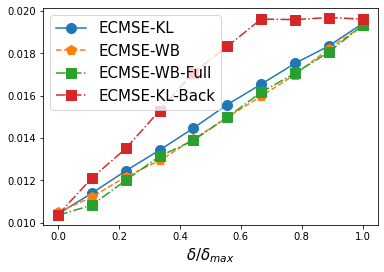

In [30]:
plt.plot(deltalist_complex,(np.mean(np.power(np.std(mreturn_i_complex-mreturn_o_complex,axis=1),2),axis=0)+np.power(np.maximum(np.mean(sds_r - sds_o_r,axis=0),0),2)),marker="o",markersize=10,label = "ECMSE-KL")

plt.plot(deltalist_complex,(np.mean(np.power(np.std(mreturn_i_complex_wb-mreturn_o_complex_wb,axis=1),2),axis=0)+np.power(np.maximum(np.mean(sds_r_wb - sds_o_r_wb,axis=0),0),2)),marker="p",markersize=10,linestyle='dashed', label = "ECMSE-WB")

plt.plot(deltalist_complex,(np.mean(np.power(np.std(mreturn_i_complex_wb_general-mreturn_o_complex_wb_general,axis=1),2),axis=0)+np.power(np.maximum(np.mean(sds_r_wb_general - sds_o_r_wb_general,axis=0),0),2)),marker="s",markersize=10,linestyle='-.', label = "ECMSE-WB-Full")

plt.plot(deltalist_complex,(np.mean(np.power(np.std(mreturn_i_complex_kl_back-mreturn_o_complex_kl_back,axis=1),2),axis=0)+np.power(np.maximum(np.mean(sds_r_kl_back - sds_o_r_kl_back,axis=0),0),2)),marker="s",markersize=10,linestyle='-.', label = "ECMSE-KL-Back")


plt.xlabel(r'$\delta/\delta_{max}$',fontsize=15)
plt.legend()
plt.legend(fontsize=15)
plt.show()

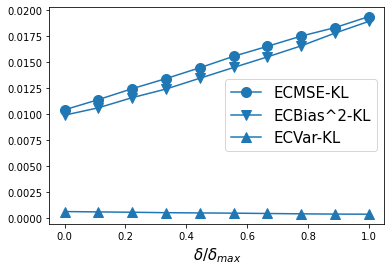

In [31]:
plt.plot(deltalist_complex,(np.mean(np.power(np.std(mreturn_i_complex-mreturn_o_complex,axis=1),2),axis=0)+np.power(np.maximum(np.mean(sds_r - sds_o_r,axis=0),0),2)),marker="o",markersize=10,label = "ECMSE-KL")
plt.plot(deltalist_complex,np.power(np.maximum(np.mean(sds_r_wb - sds_o_r_wb,axis=0),0),2),marker="v",markersize=10,color = '#1f77b4', label = "ECBias^2-KL")
plt.plot(deltalist_complex,np.mean(np.power(np.std(mreturn_i_complex-mreturn_o_complex,axis=1),2),axis=0),marker="^",markersize=10,color='#1f77b4',label = "ECVar-KL")
plt.xlabel(r'$\delta/\delta_{max}$',fontsize=15)
plt.legend()
plt.legend(fontsize=15)
plt.show()

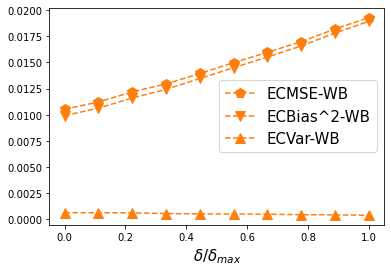

In [32]:
plt.plot(deltalist_complex,(np.mean(np.power(np.std(mreturn_i_complex_wb-mreturn_o_complex_wb,axis=1),2),axis=0)+np.power(np.maximum(np.mean(sds_r_wb - sds_o_r_wb,axis=0),0),2)),marker="p",markersize=10,linestyle='dashed',color='#ff7f0e',label = "ECMSE-WB")
plt.plot(deltalist_complex,np.power(np.maximum(np.mean(sds_r_wb - sds_o_r_wb,axis=0),0),2),marker="v",markersize=10,color='#ff7f0e',linestyle='dashed',label = "ECBias^2-WB")
plt.plot(deltalist_complex,np.mean(np.power(np.std(mreturn_i_complex_wb-mreturn_o_complex_wb,axis=1),2),axis=0),marker="^",markersize=10,color='#ff7f0e',linestyle='dashed',label = "ECVar-WB")
plt.xlabel(r'$\delta/\delta_{max}$',fontsize=15)
plt.legend()
plt.legend(fontsize=15)
plt.show()

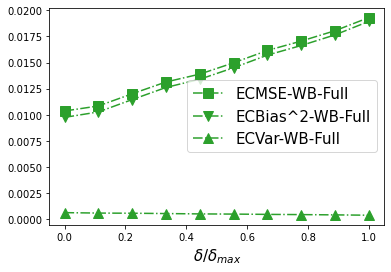

In [33]:
plt.plot(deltalist_complex,(np.mean(np.power(np.std(mreturn_i_complex_wb_general-mreturn_o_complex_wb_general,axis=1),2),axis=0)+np.power(np.maximum(np.mean(sds_r_wb_general - sds_o_r_wb_general,axis=0),0),2)),marker="s",markersize=10,linestyle='-.',color='#2ca02c',label = "ECMSE-WB-Full")
plt.plot(deltalist_complex,np.power(np.maximum(np.mean(sds_r_wb_general - sds_o_r_wb_general,axis=0),0),2),marker="v",markersize=10,color='#2ca02c',linestyle='-.',label = "ECBias^2-WB-Full")
plt.plot(deltalist_complex,np.mean(np.power(np.std(mreturn_i_complex_wb_general-mreturn_o_complex_wb_general,axis=1),2),axis=0),marker="^",markersize=10,color='#2ca02c',linestyle='-.',label = "ECVar-WB-Full")
plt.xlabel(r'$\delta/\delta_{max}$',fontsize=15)
plt.legend()
plt.legend(fontsize=15)
plt.show()

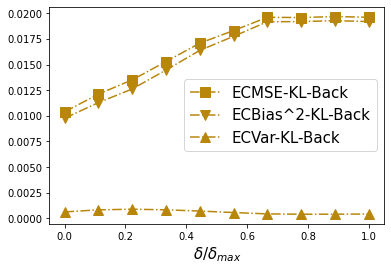

In [34]:
plt.plot(deltalist_complex,(np.mean(np.power(np.std(mreturn_i_complex_kl_back-mreturn_o_complex_kl_back,axis=1),2),axis=0)+np.power(np.maximum(np.mean(sds_r_kl_back - sds_o_r_kl_back,axis=0),0),2)),marker="s",markersize=10,linestyle='-.',color='#B8860B',label = "ECMSE-KL-Back")
plt.plot(deltalist_complex,np.power(np.maximum(np.mean(sds_r_kl_back - sds_o_r_kl_back,axis=0),0),2),marker="v",markersize=10,color='#B8860B',linestyle='-.',label = "ECBias^2-KL-Back")
plt.plot(deltalist_complex,np.mean(np.power(np.std(mreturn_i_complex_kl_back-mreturn_o_complex_kl_back,axis=1),2),axis=0),marker="^",markersize=10,color='#B8860B',linestyle='-.',label = "ECVar-KL-Back")
plt.xlabel(r'$\delta/\delta_{max}$',fontsize=15)
plt.legend()
plt.legend(fontsize=15)
plt.show()